<a href="https://colab.research.google.com/github/yshibata8513/kalman_filter/blob/master/0808_smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np

In [2]:
class BasePlantModel(nn.Module):
    
    def __init__(self,use_control,Q):
        super().__init__()
        self.use_control = use_control
        self._Q = Q
    
    def forward(self,**argv):
        raise NotImplementedError()
        
    def F(self,state,control,dt):
        _state = torch.nn.Parameter(state.data.clone())
        if self.use_control:
            control = control.data.clone()
        state_ = self.forward(_state,control,dt)
        F = torch.cat([torch.autograd.grad(outputs=s_, inputs=_state, create_graph=False, retain_graph=True)[0].view(1,-1) for s_ in state_],dim=0)
        return F
    
    def B(self,state,control,dt):
        if self.use_control==False:
            return None
        _state = state.data.clone()
        control = torch.nn.Parameter(control.data.clone())
        state_ = self.forward(_state,control,dt)
        B = torch.cat([torch.autograd.grad(outputs=c, inputs=_state, create_graph=False, retain_graph=True)[0].view(1,-1) for c in control],dim=0)
        return B

    @property
    def Q(self):
        return self._Q.data.clone()

In [3]:
class BaseObserverModel(nn.Module):
    
    def __init__(self,R):
        super().__init__()
        self._R = R
    
    def forward(self,**argv):
        raise NotImplementedError()
        
    def H(self,state):
        _state = torch.nn.Parameter(state.data.clone())

        obs = self.forward(_state)
        #H = torch.autograd.grad(outputs=obs, inputs=_state, create_graph=False)
        H = torch.cat([torch.autograd.grad(outputs=o, inputs=_state, create_graph=False, retain_graph=True)[0].view(1,-1) for o in obs],dim=0)
        return H
    
    @property
    def R(self):
        return self._R.data.clone()

In [4]:
class Kinematic_1d(BasePlantModel):
    def __init__(self):
        super().__init__(use_control=True,Q=torch.FloatTensor([[0.01,0],[0.,0.01]]))
        self.dim_state = 2
        self.dim_control = 1
        self._F = torch.FloatTensor([[0,1],[0,0]])
        self._B = torch.FloatTensor([0,1]).view(2,1)
        #self._Q = torch.FloatTensor([[0.01,0],[0.,0.01]])
        
    def forward(self,state,control,dt):
        F = self.F_(state,control,dt)
        B = self.B_(state,control,dt)
        return F@state + B@control
        
    #@property
    def F_(self,state,control,dt):
        return torch.eye(2) + self._F*dt
        
    #@property
    def B_(self,state,control,dt):
        return self._B*dt
        
#     @property
#     def Q(self):
#         return self._Q

In [5]:
class ObsPosition_1d(BaseObserverModel):
    def __init__(self,R=torch.FloatTensor([0.5])):
        super().__init__(R)
        self.dim_state = 2
        self.dim_obs = 1
        self._H = torch.FloatTensor([1,0]).view(1,-1)
        #self._R = torch.FloatTensor([0.5])
        
#     def H(self,state):
#         return self._H

    @property
    def R(self):
        return self._R
    
    def forward(self,state):
        return self._H@state

In [6]:
class KalmanFilterCalculator(nn.Module):
    def __init__(self,plant,observer):
        super().__init__()
        self.plant = plant
        self.observer = observer
    
    def _prediction(self,_state,control,dt,_P):
        state_ = self.plant(_state,control,dt)
        F = self.plant.F(_state,control,dt)
        Q = self.plant.Q
        P_ = F@_P@F.T + Q
        return state_,P_
    
    def _filtering(self,_state,dt,_P,obs):
        
        H = self.observer.H(_state)
        R = self.observer.R
        
        K = _P@H.T@(H@_P@H.T + R).inverse()

        obs_pred = self.observer(_state)
        
        state_ = _state + K@(obs - obs_pred)
        P_ = _P - K@H@_P
        
        return state_,P_
        
        
    def _smoothing(self,state_p,state_f,_state_s,control,P_p,P_f,_P_s,dt):
        F = self.plant.F(state_f,control,dt)
        A = P_f@F.T@P_p.inverse()
        state_s_ = state_f +A@(_state_s - state_p)
        P_s_ = P_f + A@(_P_s - P_p)@A.T
        return state_s_,P_s_
    
    

In [7]:
class KalamanFilter:
    def __init__(self,calculator):
        self.calculator = calculator
        
    def filtering(self,s_init,P_init,dts,observations,controls=None):
        Ss_p = [s_init.view(-1,1)]
        Ss_f = [s_init.view(-1,1)]
        Ps_p = [P_init]
        Ps_f = [P_init]
        p = P_init
        s = s_init
        T = len(observations)
        if controls == None:
          controls = torch.zeros(T)
        for t in range(T):
            dt = dts[t]
            c = controls[t]
            obs = observations[t].view(-1,1)
            s,p = self.calculator._prediction(s.view(-1,1),c.view(-1,1),dt,p)
            Ss_p.append(s.data.clone())
            Ps_p.append(p.data.clone())
            s,p = self.calculator._filtering(s.view(-1,1),dt,p,obs)
            Ss_f.append(s.data.clone())
            Ps_f.append(p.data.clone())
        Ss_p = torch.cat([s.view(1,-1) for s in Ss_p])
        Ss_f = torch.cat([s.view(1,-1) for s in Ss_f])
        h = w = Ps_p[0].size()[0]
        Ps_p = torch.cat([s.view(1,h,w) for s in Ps_p])
        Ps_f = torch.cat([s.view(1,h,w) for s in Ps_f])
        return Ss_p,Ps_p,Ss_f,Ps_f

    def smoothing(self,Ss_p,Ss_f,Ps_p,Ps_f,controls=None):

        s = Ss_f[-1]
        p = Ps_f[-1]
        Ss_s = [Ss_f[-1]]
        Ps_s = [Ps_f[-1]]
        T = len(Ss_p) - 1
        if controls == None:
          controls = torch.zeros(T)
        for _t in range(T):
            t = T - _t 
            #print(_t,t)
            s_p = Ss_p[t]
            s_f = Ss_f[t-1]
            P_p = Ps_p[t]
            P_f = Ps_f[t-1]
            c = controls[t-1]
            s,p = self.calculator._smoothing(s_p.view(-1,1),s_f.view(-1,1),s.view(-1,1),c.view(-1,1),P_p,P_f,p,dt)
            #print(s.size())
            Ss_s.append(s.data.clone())
            Ps_s.append(p.data.clone())
        #print(Ss_s[0].size(),Ss_s[1].size())
        Ss_s = torch.Tensor(np.array(torch.cat([s.view(1,-1) for s in Ss_s]))[::-1].copy())
        #Ss_s = torch.stack(Ss_s,dim=0).view(-1,2).data.numpy()[::-1].copy()
        h = w = Ps_p[0].size()[0]
        Ps_s = torch.Tensor(np.array(torch.cat([s.view(1,h,w) for s in Ps_s]))[::-1].copy())
        return Ss_s,Ps_s 
    

In [8]:
dt = 0.5
x =  torch.arange(100)*dt + torch.randn(100)*0.5
x[0] = 0
v = torch.ones(100).float()
states = torch.stack([x,v],dim=-1)
controls = torch.zeros_like(x)
observations = states[1:,0]

#states

In [9]:
P0 = torch.FloatTensor([[0.01,0],[0.,0.01]])
s0 = states[0]
c0 = controls[0]

p_model = Kinematic_1d()
o_model = ObsPosition_1d()
kfc = KalmanFilterCalculator(p_model,o_model)
kf = KalamanFilter(kfc)
dts = torch.ones(99)*0.5

In [10]:
Ss_p,Ps_p,Ss_f,Ps_f = kf.filtering(s0,P0,dts,observations)
print(Ss_p.size(),Ps_p.size(),Ss_f.size(),Ps_f.size())
Ss_s,Ps_s =  kf.smoothing(Ss_p=Ss_p,Ps_p=Ps_p,Ss_f=Ss_f,Ps_f=Ps_f)
Ss_s.size()

torch.Size([100, 2]) torch.Size([100, 2, 2]) torch.Size([100, 2]) torch.Size([100, 2, 2])


torch.Size([100, 2])

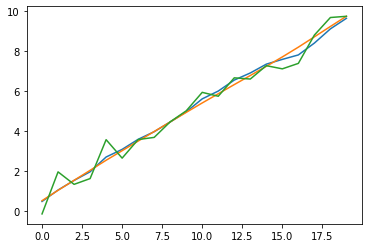

In [12]:
import matplotlib.pyplot as plt

plt.plot(Ss_f[1:21,0])
plt.plot(Ss_s[1:21,0])
plt.plot(observations[:20])

In [ ]:

#plt.plot(observations[:20])

In [ ]:
#_Ss_p = torch.cat(Ss_p[1:],dim=0)
plt.plot(_Ss_p[1:20,0])
plt.plot(_Ss_f[1:20,0])
plt.plot(_Ss_a[1:20])
plt.plot(observations[:19])

In [ ]:
# Ss_p = []
# Ss_f = []
# Ps_p = []
# Ps_f = []
# p = P0
# s = s0
# for t in range(100-1):
#     s,p = kf._prediction(s.view(2,1),c0.view(1,1),dt,p)
#     Ss_p.append(s.data.clone())
#     Ps_p.append(p.data.clone())
    
#     s,p = kf._filtering(s.view(2,1),c0.view(1,1),dt,p,states[t+1,0].view(1,1))
#     Ss_f.append(s.data.clone())
#     Ps_f.append(p.data.clone())
    
# len(Ss_p),len(Ss_f),len(Ps_p),len(Ps_f)


In [ ]:
Ss_p[1].size(),Ss_p[2].size(),Ss_f[0].size(),Ss_f[1].size()

In [ ]:
s = Ss_f[-1]
p = Ps_f[-1]
Ss_s = [Ss_f[-1]]
Ps_s = [Ps_f[-1]]

for _t in range(99):
    t = 99 - (_t )

    

    s_p = Ss_p[t]
    s_f = Ss_f[t-1]
    P_p = Ps_p[t]
    P_f = Ps_f[t-1]
    s,p = kfc._smoothing(s_p,s_f,s,c0.view(1,1),P_p,P_f,p,dt)
    Ss_s.append(s.data.clone())


    Ps_s.append(p.data.clone())



In [ ]:
#_Ss_f = torch.cat([s.view(1,-1) for s in Ss_f],dim=0)


In [ ]:
plt.plot(_Ss_f[:20,0])
plt.plot(_Ss_s[:20,0]),len(_Ss_f),len(_Ss_s)

In [ ]:
_Ss_s = torch.stack(Ss_s,dim=0).view(-1,2).data.numpy()[::-1].copy()
_Ss_f = torch.stack(Ss_f,dim=0)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(_Ss_s[:,0][:10])
plt.plot(_Ss_f[:,0][:10])
plt.plot(states[:,0][1:11])

In [ ]:
len(_Ss_s)